# Coordinate-based meta-regression algorithms

A tour of CBMR algorithms in NiMARE
This tutorial is intended to provide a brief description and example of the CBMR algorithm implemented in NiMARE. For a more detailed introduction to the elements of a coordinate-based meta-regression, see other stuff.

In [1]:
from nimare.utils import get_masker, B_spline_bases, dummy_encoding_moderators, get_resource_path,index2vox
from nimare.tests.utils import standardize_field
from nimare.meta import models

from nilearn.plotting import plot_stat_map
from nimare.generate import create_coordinate_dataset
import nibabel as nib

import numpy as np
import scipy
import logging
import sys

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## Load Dataset

In [2]:
# data simulation
ground_truth_foci, dset = create_coordinate_dataset(foci=10, sample_size=(20, 40), n_studies=1000)
# set up group columns: diagnosis & drug_status  
n_rows = dset.annotations.shape[0]
dset.annotations['diagnosis'] = ["schizophrenia" if i%2==0 else 'depression' for i in range(n_rows)]
dset.annotations['drug_status'] = ['Yes' if i%2==0 else 'No' for i in range(n_rows)]
dset.annotations['drug_status'] = dset.annotations['drug_status'].sample(frac=1).reset_index(drop=True) # random shuffle drug_status column
# set up continuous moderators: sample sizes & avg_age
dset.annotations["sample_sizes"] = [dset.metadata.sample_sizes[i][0] for i in range(n_rows)] 
dset.annotations["avg_age"] = np.arange(n_rows)
# set up categorical moderators: schizophrenia_subtype (as not enough data to be interpreted as groups)
dset.annotations['schizophrenia_subtype'] = ["type1", "type2", "type3", "type4", "type5"] * int(n_rows/5)
dset.annotations['schizophrenia_subtype'] = dset.annotations['schizophrenia_subtype'].sample(frac=1).reset_index(drop=True) # random shuffle drug_status column


# Estimation of group-specific spatial intensity functions
Unlike kernel-based CBMR methods (e.g. ALE, MKDA and SDM), CBMR provides a generative regression model that estimates a smooth intensity function and can have study-level moderators. It's developed with a spatial model to induce a smooth response and model the entire image jointly, and fitted with different variants of statistical distributions (Poisson, Negative Binomial (NB) or Clustered NB model) to find the most accurate but parsimonious model.

CBMR framework can generate estimation of group-specific spatial internsity functions for multiple groups simultaneously, with different group-specific spatial regression coefficients. 

CBMR framework can also consider the effects of study-level moderators (e.g. sample size, year of publication) by estimating regression coefficients of moderators (shared by all groups). Note that moderators can only have global effects instead of localized effects within CBMR framework. In the scenario that there're multiple subgroups within a group, while one or more of them don't have enough number of studies to be inferred as a separate group, CBMR can interpret them as categorical study-level moderators.  

INFO:nimare.diagnostics:0/10000 coordinates fall outside of the mask. Removing them.
/well/nichols/users/pra123/anaconda3/envs/torch/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


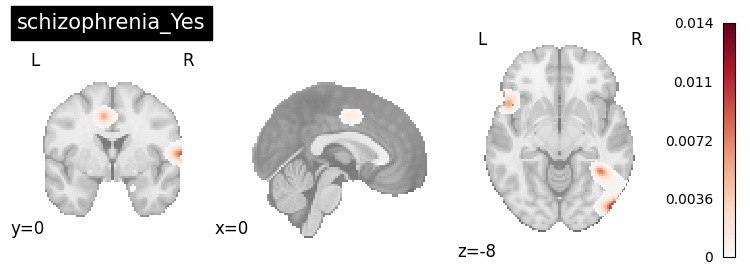

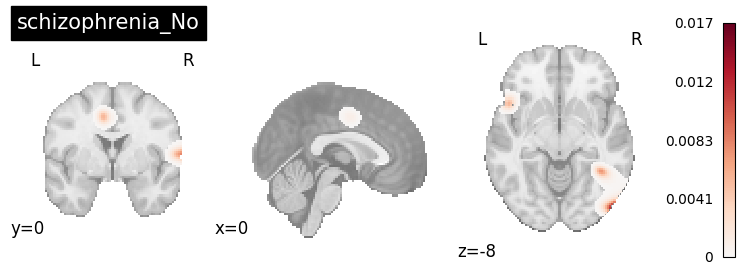

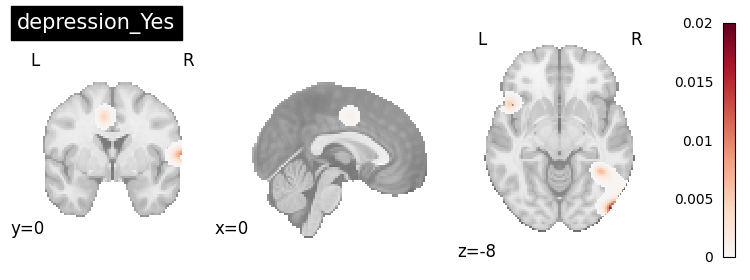

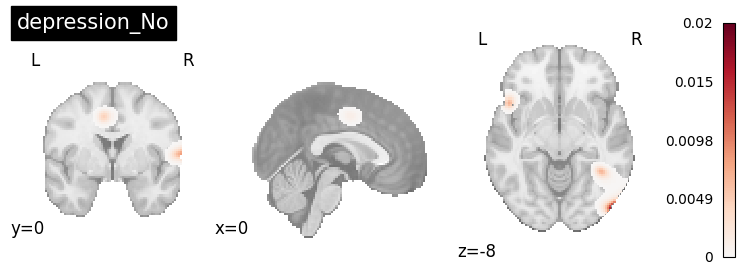

In [3]:
from nimare.meta.cbmr import CBMREstimator
dset = standardize_field(dataset=dset, metadata=["sample_sizes", "avg_age"])
cbmr = CBMREstimator(
    group_categories=["diagnosis", "drug_status"],
    moderators=["standardized_sample_sizes", "standardized_avg_age", "schizophrenia_subtype"],
    spline_spacing=10,
    model=models.PoissonEstimator,
    penalty=False,
    lr=1e-1,
    tol=1e1,
    device="cpu"
)
cres = cbmr.fit(dataset=dset)
plot_stat_map(
    cres.get_map("Group_schizophrenia_Yes_Studywise_Spatial_Intensity"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="schizophrenia_Yes",
    threshold=1e-4
)
plot_stat_map(
    cres.get_map("Group_schizophrenia_No_Studywise_Spatial_Intensity"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="schizophrenia_No",
    threshold=1e-4
)
plot_stat_map(
    cres.get_map("Group_depression_Yes_Studywise_Spatial_Intensity"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="depression_Yes",
    threshold=1e-4
)
plot_stat_map(
    cres.get_map("Group_depression_No_Studywise_Spatial_Intensity"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="depression_No",
    threshold=1e-4
)


Four figures correspond to group-specific spatial intensity map of four groups ("schizophrenia_Yes", "schizophrenia_No", "depression_Yes", "depression_No"). Areas with stronger spatial intensity are highlighted. 

## Generalized Linear Hypothesis (GLH) testing for spatial homogeneity

In the most basic scenario of spatial homogeneity test, contrast matrix `t_con_groups` can be generated by `create_contrast` function, with group names specified. 

INFO:nimare.meta.cbmr:Group Reference in contrast array
INFO:nimare.meta.cbmr:schizophrenia_No = index_0
INFO:nimare.meta.cbmr:depression_No = index_1
INFO:nimare.meta.cbmr:depression_Yes = index_2
INFO:nimare.meta.cbmr:schizophrenia_Yes = index_3
INFO:nimare.meta.cbmr:Moderator Reference in contrast array
INFO:nimare.meta.cbmr:standardized_sample_sizes = index_0
INFO:nimare.meta.cbmr:standardized_avg_age = index_1
INFO:nimare.meta.cbmr:type5 = index_2
INFO:nimare.meta.cbmr:type1 = index_3
INFO:nimare.meta.cbmr:type4 = index_4
INFO:nimare.meta.cbmr:type3 = index_5


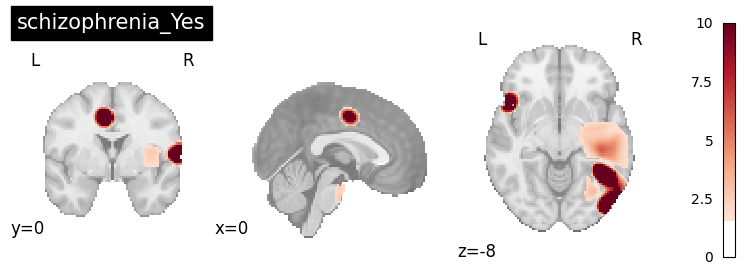

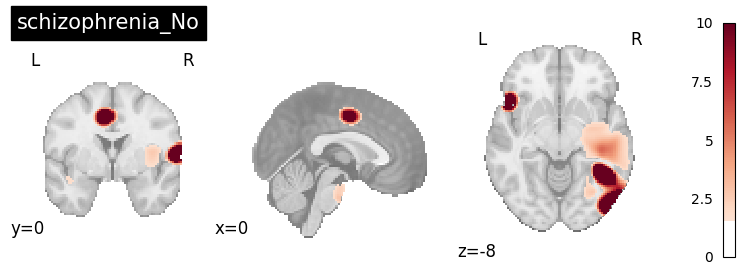

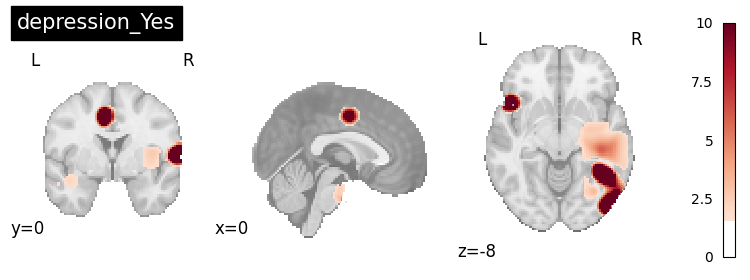

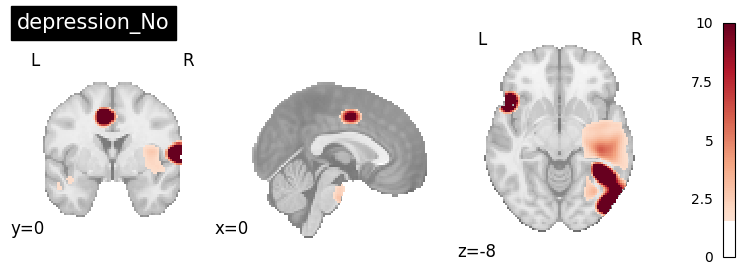

In [4]:
from nimare.meta.cbmr import CBMRInference
inference = CBMRInference(
        CBMRResults=cres, device="cuda"
    )
t_con_groups = inference.create_contrast(["schizophrenia_Yes", "schizophrenia_No", "depression_Yes", "depression_No"], type="groups")
contrast_result = inference.compute_contrast(t_con_groups=t_con_groups, t_con_moderators=False)

# generate chi-square maps for each group
plot_stat_map(
    cres.get_map("schizophrenia_Yes_z_statistics"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="schizophrenia_Yes",
    threshold=scipy.stats.norm.isf(0.05)
)

plot_stat_map(
    cres.get_map("schizophrenia_No_z_statistics"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="schizophrenia_No",
    threshold=scipy.stats.norm.isf(0.05)
)

plot_stat_map(
    cres.get_map("depression_Yes_z_statistics"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="depression_Yes",
    threshold=scipy.stats.norm.isf(0.05)
)

plot_stat_map(
    cres.get_map("depression_No_z_statistics"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="depression_No",
    threshold=scipy.stats.norm.isf(0.05)
)

Four figures (displayed as z-statistics map) correspond to homogeneity test of group-specific spatial intensity for four groups. The null hypothesis assumes homogeneous spatial intensity over the whole brain, $H_0: \mu_j = \mu_0 = sum(n_{\text{foci}})/N$, $j=1, \cdots, N$, where $N$ is the number of voxels within brain mask, $j$ is the index of voxel. Areas with significant p-values are highlighted (under significance level $0.05$). 

# GLH testing for group comparisons among any two groups

In the most basic scenario of group comparison test, contrast matrix `t_con_groups` can be generated by `create_contrast` function, with `contrast_name` specified as "group1-group2". 

INFO:nimare.meta.cbmr:Group Reference in contrast array
INFO:nimare.meta.cbmr:schizophrenia_No = index_0
INFO:nimare.meta.cbmr:depression_No = index_1
INFO:nimare.meta.cbmr:depression_Yes = index_2
INFO:nimare.meta.cbmr:schizophrenia_Yes = index_3
INFO:nimare.meta.cbmr:Moderator Reference in contrast array
INFO:nimare.meta.cbmr:standardized_sample_sizes = index_0
INFO:nimare.meta.cbmr:standardized_avg_age = index_1
INFO:nimare.meta.cbmr:type5 = index_2
INFO:nimare.meta.cbmr:type1 = index_3
INFO:nimare.meta.cbmr:type4 = index_4
INFO:nimare.meta.cbmr:type3 = index_5


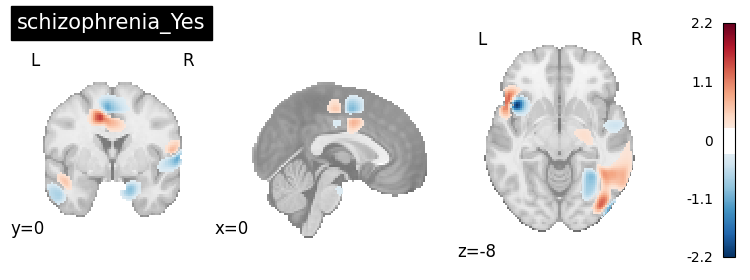

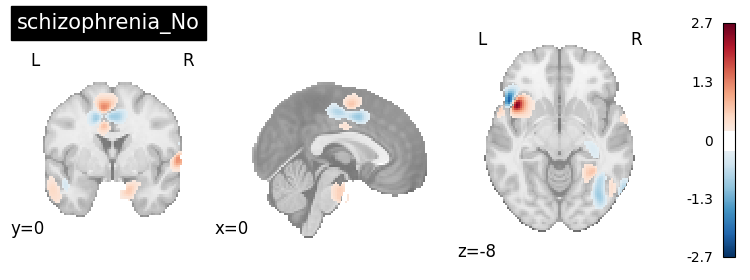

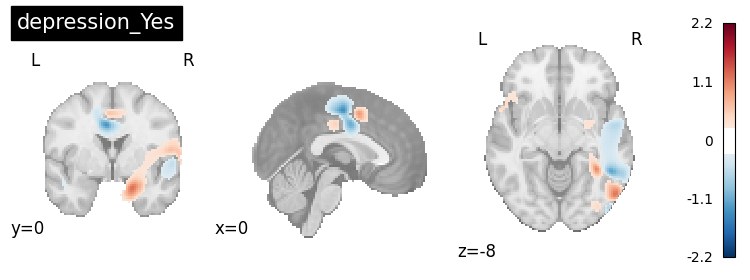

In [5]:
inference = CBMRInference(
        CBMRResults=cres, device="cuda"
    )
t_con_groups = inference.create_contrast(["schizophrenia_Yes-schizophrenia_No", "schizophrenia_No-depression_Yes", "depression_Yes-depression_No"], type="groups")
contrast_result = inference.compute_contrast(t_con_groups=t_con_groups, t_con_moderators=False)

# generate z-statistics maps for each group
plot_stat_map(
    cres.get_map("schizophrenia_Yes-schizophrenia_No_z_statistics"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="schizophrenia_Yes",
    threshold=scipy.stats.norm.isf(0.4)
)

plot_stat_map(
    cres.get_map("schizophrenia_No-depression_Yes_z_statistics"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="schizophrenia_No",
    threshold=scipy.stats.norm.isf(0.4)
)

plot_stat_map(
    cres.get_map("depression_Yes-depression_No_z_statistics"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="depression_Yes",
    threshold=scipy.stats.norm.isf(0.4)
)


Four figures (displayed as z-statistics map) correspond to group comparison test of spatial intensity for any two groups. The null hypothesis assumes spatial intensity estimations of two groups are equal at voxel level, $H_0: \mu_{1j}=\mu_{2j}$, $j=1, \cdots, N$, where $N$ is the number of voxels within brain mask, $j$ is the index of voxel. Areas with significant p-values (significant difference in spatial intensity estimation between two groups) are highlighted (under significance level $0.05$). 




# GLH testing with contrast matrix specified 

CBMR supports more flexible GLH test by specifying a contrast matrix. For example, group comparison test `2xgroup_0-1xgroup_1-1xgroup_2` can be represented as `t_con_group=[2, -1, -1, 0]`, as an input in `compute_contrast` function. Multiple independent GLH tests can be conducted simultaneously by including multiple contrast vectors/matrices in `t_con_group`. 

CBMR also allows simultaneous GLH tests (consisting of multiple contrast vectors) when it's represented as one of elements in `t_con_group` (datatype: list). Only if all of null hypotheses are rejected at voxel level, p-values are significant. For example, `t_con_group=[[1,-1,0,0], [1,0,-1,0], [0,0,1,-1]]` is used for testing the equality of spatial intensity estimation among all of four groups (finding the consistent activation regions). Note that only $n-1$ contrast vectors are necessary for testing the equality of $n$ groups. 


INFO:nimare.meta.cbmr:Group Reference in contrast array
INFO:nimare.meta.cbmr:schizophrenia_No = index_0
INFO:nimare.meta.cbmr:depression_No = index_1
INFO:nimare.meta.cbmr:depression_Yes = index_2
INFO:nimare.meta.cbmr:schizophrenia_Yes = index_3
INFO:nimare.meta.cbmr:Moderator Reference in contrast array
INFO:nimare.meta.cbmr:standardized_sample_sizes = index_0
INFO:nimare.meta.cbmr:standardized_avg_age = index_1
INFO:nimare.meta.cbmr:type5 = index_2
INFO:nimare.meta.cbmr:type1 = index_3
INFO:nimare.meta.cbmr:type4 = index_4
INFO:nimare.meta.cbmr:type3 = index_5


The contrast matrix of GLH_0 is [[1, -1, 0, 0], [1, 0, -1, 0], [0, 0, 1, -1]]


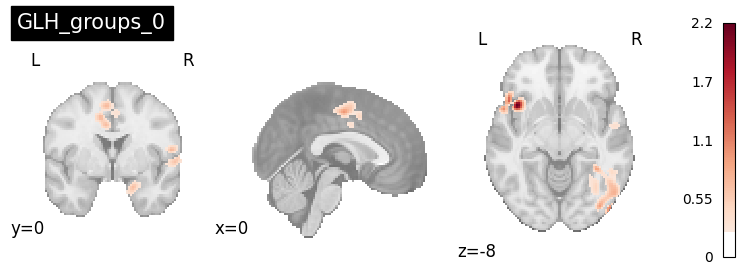

In [6]:
inference = CBMRInference(
        CBMRResults=cres, device="cuda"
    )
contrast_result = inference.compute_contrast(t_con_groups=[[[1,-1,0,0], [1,0,-1,0], [0,0,1,-1]]], t_con_moderators=False)
plot_stat_map(
    cres.get_map("GLH_groups_0_z_statistics"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    title="GLH_groups_0",
    threshold=scipy.stats.norm.isf(0.4)
)
print("The contrast matrix of GLH_0 is {}".format(cres.metadata["GLH_groups_0"]))

# GLH testing for study-level moderators 

CBMR framework can estimate global study-level moderator effects, and allows inference on the existence of m . 

In [14]:
inference = CBMRInference(
    CBMRResults=cres, device="cuda"
)
contrast_name = cres.estimator.moderators
t_con_moderators = inference.create_contrast(contrast_name, type="moderators")
contrast_result = inference.compute_contrast(t_con_groups=False, t_con_moderators=t_con_moderators)
print(cres.tables["Moderators_Regression_Coef"])
print("P-values of moderator effects `sample_sizes` is {}".format(cres.tables["standardized_sample_sizes_p_values"]))
print("P-value of moderator effects `avg_age` is {}".format(cres.tables["standardized_avg_age_p_values"]))

INFO:nimare.meta.cbmr:Group Reference in contrast array
INFO:nimare.meta.cbmr:schizophrenia_No = index_0
INFO:nimare.meta.cbmr:depression_No = index_1
INFO:nimare.meta.cbmr:depression_Yes = index_2
INFO:nimare.meta.cbmr:schizophrenia_Yes = index_3
INFO:nimare.meta.cbmr:Moderator Reference in contrast array
INFO:nimare.meta.cbmr:standardized_sample_sizes = index_0
INFO:nimare.meta.cbmr:standardized_avg_age = index_1
INFO:nimare.meta.cbmr:type5 = index_2
INFO:nimare.meta.cbmr:type1 = index_3
INFO:nimare.meta.cbmr:type4 = index_4
INFO:nimare.meta.cbmr:type3 = index_5


   standardized_sample_sizes  standardized_avg_age     type5     type1  \
0                   -0.00109              0.000588 -0.027104 -0.025923   

      type4     type3  
0 -0.026694 -0.027402  
P-values of moderator effects `sample_sizes` is 0.9130485642134478
P-value of moderator effects `avg_age` is 0.9529915576540059


This table shows the regression coefficients of study-level moderators, here, `sample_sizes` and `avg_age` are standardized in the preprocessing steps. Moderator effects of both `sample_size` and `avg_age` are not significant under significance level $0.05$. With reference to spatial intensity estimation of a chosen subtype, spatial intensity estimations of the other $4$ subtypes of schizophrenia are moderatored globally.

In [16]:
inference = CBMRInference(
    CBMRResults=cres, device="cuda"
)
t_con_moderators = inference.create_contrast(["standardized_sample_sizes-standardized_avg_age"], type="moderators")
contrast_result = inference.compute_contrast(t_con_groups=False, t_con_moderators=t_con_moderators)
print("P-values of difference in two moderator effectors (`sample_size-avg_age`) is {}".format(cres.tables["standardized_sample_sizes-standardized_avg_age_p_values"]))

INFO:nimare.meta.cbmr:Group Reference in contrast array
INFO:nimare.meta.cbmr:schizophrenia_No = index_0
INFO:nimare.meta.cbmr:depression_No = index_1
INFO:nimare.meta.cbmr:depression_Yes = index_2
INFO:nimare.meta.cbmr:schizophrenia_Yes = index_3
INFO:nimare.meta.cbmr:Moderator Reference in contrast array
INFO:nimare.meta.cbmr:standardized_sample_sizes = index_0
INFO:nimare.meta.cbmr:standardized_avg_age = index_1
INFO:nimare.meta.cbmr:type5 = index_2
INFO:nimare.meta.cbmr:type1 = index_3
INFO:nimare.meta.cbmr:type4 = index_4
INFO:nimare.meta.cbmr:type3 = index_5


P-values of difference in two moderator effectors (`sample_size-avg_age`) is 0.9054368009582764


CBMR also allows flexible contrasts between study-level covariates. For example, we can write `contrast_name` (an input to `create_contrast` function) as `standardized_sample_sizes-standardized_avg_age` when exploring if the moderator effects of `sample_sizes` and `avg_age` are equivalent. 